# Airbnb Descriptive

<p>Now that we have the predictive model complete, we now look to address the qualities that most affect the experience of Airbnb guests. 
Namely, these include quality features, bedrooms, bathrooms and seasonal features that enchance/detract from one's stay.</p>

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
prices = pd.read_csv('data/Ames_Housing_Price_Data.csv',index_col = 0)


In [60]:
#Engineering new features relevant to Airbnb experience
prices['YrSinceUpdate'] = 2010-prices['YearRemodAdd']
prices.drop('YearRemodAdd',axis = 1,inplace = True)
prices['Total_FullBaths'] = prices['BsmtFullBath'] + prices['FullBath']
prices['Total_HalfBaths'] = prices['BsmtHalfBath'] + prices['HalfBath']
prices.drop(['BsmtFullBath','FullBath','BsmtHalfBath','HalfBath'],axis = 1, inplace = True)

In [61]:
airbnb_cols = ['PID','SalePrice','GrLivArea','BldgType','HouseStyle','OverallQual','OverallCond',
              'YearBuilt','YrSinceUpdate','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtFinType1',
              'BsmtFinType2','HeatingQC','CentralAir','Total_FullBaths','Total_HalfBaths','FireplaceQu',
              'BedroomAbvGr','KitchenQual','GarageQual','GarageCond',
               'PoolQC','Fence','MiscFeature','Functional',"Neighborhood"]
prices = prices[airbnb_cols]
prices

,PID,SalePrice,GrLivArea,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YrSinceUpdate,ExterQual,...,FireplaceQu,BedroomAbvGr,KitchenQual,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,Functional,Neighborhood
1,909176150,126000,856,1Fam,1Story,6,6,1939,60,TA,...,Gd,2,TA,TA,TA,NaN,NaN,NaN,Typ,SWISU
2,905476230,139500,1049,TwnhsE,1Story,5,5,1984,26,Gd,...,NaN,2,Gd,TA,TA,NaN,NaN,NaN,Typ,Edwards
3,911128020,124900,1001,1Fam,1Story,5,9,1930,3,Gd,...,NaN,2,Gd,TA,Po,NaN,NaN,NaN,Typ,IDOTRR
4,535377150,114000,1039,1Fam,2Story,4,8,1900,7,Gd,...,NaN,2,TA,TA,TA,NaN,NaN,NaN,Typ,OldTown
5,534177230,227000,1665,1Fam,2Story,8,6,2001,9,Gd,...,NaN,3,Gd,TA,TA,NaN,NaN,NaN,Typ,NWAmes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,903205040,121000,952,1Fam,1.5Unf,6,6,1916,60,TA,...,Gd,2,Fa,Fa,Po,NaN,NaN,NaN,Typ,BrkSide
760,905402060,139600,1733,1Fam,1Story,3,5,1955,55,TA,...,Gd,4,TA,TA,TA,NaN,NaN,NaN,Min2,Edwards
761,909275030,145000,2002,Duplex,2Story,5,6,1949,60,TA,...,NaN,4,TA,TA,TA,NaN,NaN,NaN,Typ,Crawfor
762,907192040,217500,1842,1Fam,2Story,7,5,2000,10,Gd,...,TA,3,Gd,TA,TA,NaN,NaN,NaN,Typ,CollgCr


### Ensure brand quality by filtering out lower quality houses

In [62]:
prices = prices.loc[(prices.BsmtFinType1!= 'LwQ') & (prices.BsmtFinType1 !='Unf')]
prices = prices.loc[(prices.BsmtFinType2!= 'LwQ') & (prices.BsmtFinType2 !='Unf')]
prices = prices.loc[(prices.Functional == 'Typ')&(prices.OverallQual >=5)&(prices.OverallCond >=5)]
prices.drop('Functional',axis = 1, inplace = True)

# Converting quality/condition categoricals to numerical

In [63]:
def ordinal_scale(Series):
    '''Returns a pandas Series where quality scores are converted to integers
    
    Args:
    
    Series: a pandas Series of categorical quality scores'''
    return prices[Series].replace({'Po':None,'Fa':1,'TA':2,'Gd':3,'Ex':4})

prices['KitchenQual'] = ordinal_scale('KitchenQual')
prices['ExterQual'] = ordinal_scale('ExterQual')
prices['ExterCond'] = ordinal_scale('ExterCond')
prices['HeatingQC'] = ordinal_scale('HeatingQC')

In [64]:
prices['BsmtCond'].value_counts()

TA    143
Gd     14
Ex      1
Fa      1
Name: BsmtCond, dtype: int64

In [65]:
def switch_ordinals(Series):
    '''
    Returns a pandas series replacing null values with DNE (Does Not Exist) so they can be imputed.
    
    Args:
    

    Series: str, column name in the pandas dataframe.
    '''
    prices[Series].fillna('DNE',inplace = True)
    return prices[Series]
    
impute_cols = ['BsmtQual','BsmtCond','FireplaceQu',
               'GarageQual','GarageCond','PoolQC']

for i in impute_cols:
    prices[i] = switch_ordinals(i)

for i in impute_cols:
    prices[i].replace({'Po':None,'DNE':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace = True)
    
prices.update(prices[['Fence','BsmtFinType1','BsmtFinType2','MiscFeature']].fillna('None'))



In [66]:
prices.columns

Index(['PID', 'SalePrice', 'GrLivArea', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YrSinceUpdate', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
       'HeatingQC', 'CentralAir', 'Total_FullBaths', 'Total_HalfBaths',
       'FireplaceQu', 'BedroomAbvGr', 'KitchenQual', 'GarageQual',
       'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Neighborhood'],
      dtype='object')

In [67]:
summer_cols = ['PoolQC','CentralAir']
winter_cols = ['FireplaceQu','HeatingQC']

In [68]:
nulls = prices.isnull().sum()
nulls[nulls>1]

FireplaceQu    4
dtype: int64

In [69]:
prices['CentralAir'].replace({'N':0,'Y':1},inplace = True)


prices['Total_FullBaths'] = prices['Total_FullBaths'].fillna(prices['Total_FullBaths'].mean())
prices['Total_HalfBaths'] = prices['Total_HalfBaths'].fillna(prices['Total_HalfBaths'].mean())


In [70]:
nulls = prices.isnull().sum(axis = 0)
nulls[nulls>1]

FireplaceQu    4
dtype: int64

In [71]:
prices.dropna(axis = 0, how = 'any',inplace = True)

# Merge housing data with Geopy data

In [72]:
latlon = pd.read_csv('data/full_latlon.csv')
latlon.head()

,PID,lat,lon,dist_stadium,dist_downtown,dist_airport,coord
0,526301100,42.053808,-93.618344,4.417461,3.210441,6.102121,"(42.053808, -93.618344)"
1,526302030,42.053668,-93.618459,4.399660,3.196132,6.086080,"(42.053668, -93.618459)"
2,526302040,42.053578,-93.618276,4.395200,3.184448,6.076963,"(42.05357834520508, -93.61827582597934)"
3,526302110,42.052841,-93.618633,4.308096,3.106740,5.993553,"(42.05284062808919, -93.61863289727206)"
4,526302120,42.052853,-93.618678,4.308129,3.108530,5.994682,"(42.05285252734815, -93.61867770937495)"


In [74]:
prices = pd.merge(prices, latlon, how='inner', left_on = 'PID', right_on = 'PID' )

In [82]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              180 non-null    int64  
 1   SalePrice        180 non-null    int64  
 2   GrLivArea        180 non-null    int64  
 3   BldgType         180 non-null    object 
 4   HouseStyle       180 non-null    object 
 5   OverallQual      180 non-null    int64  
 6   OverallCond      180 non-null    int64  
 7   YearBuilt        180 non-null    int64  
 8   YrSinceUpdate    180 non-null    int64  
 9   ExterQual        180 non-null    int64  
 10  ExterCond        180 non-null    int64  
 11  BsmtQual         180 non-null    int64  
 12  BsmtCond         180 non-null    int64  
 13  BsmtFinType1     180 non-null    object 
 14  BsmtFinType2     180 non-null    object 
 15  HeatingQC        180 non-null    int64  
 16  CentralAir       180 non-null    int64  
 17  Total_FullBaths 

Convert the distances from km to miles

In [99]:
prices['dist_airport']=prices['dist_airport']*0.621371

In [100]:
prices['dist_downtown']=prices['dist_downtown']*0.621371
prices['dist_stadium']=prices['dist_stadium']*0.621371

In [101]:
prices.head()

,PID,SalePrice,GrLivArea,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YrSinceUpdate,ExterQual,...,PoolQC,Fence,MiscFeature,Neighborhood,lat,lon,dist_stadium,dist_downtown,dist_airport,coord
0,905476230,139500,1049,TwnhsE,1Story,5,5,1984,26,3,...,1,None,None,Edwards,42.024855,-93.663671,1.558185,2.566078,2.777751,"(42.024855315930424, -93.66367099341755)"
1,905476230,139500,1049,TwnhsE,1Story,5,5,1984,26,3,...,1,None,None,Edwards,42.024855,-93.663671,1.558185,2.566078,2.777751,"(42.024855315930424, -93.66367099341755)"
2,908128060,198500,1922,1Fam,SFoyer,7,5,2003,7,3,...,1,None,None,Edwards,42.019009,-93.672987,1.928481,3.074472,2.950477,"(42.01900877172312, -93.67298690279817)"
3,923252075,131250,1091,1Fam,SLvl,6,5,1993,14,2,...,1,None,Shed,Mitchel,41.987528,-93.606181,2.495401,2.622904,1.147281,"(41.98752773737374, -93.60618059595959)"
4,902201120,115000,789,1Fam,1Story,5,5,1948,60,2,...,1,None,None,OldTown,42.033518,-93.608836,1.827655,0.634668,2.485242,"(42.03351832653061, -93.6088355510204)"


In [102]:
prices['Neighborhood'].value_counts()

NAmes      59
Edwards    17
Sawyer     15
NWAmes     14
SawyerW    11
Mitchel     9
CollgCr     7
NoRidge     6
NridgHt     5
Somerst     5
Timber      5
Veenker     4
OldTown     4
ClearCr     3
IDOTRR      3
Crawfor     3
BrkSide     2
Gilbert     2
NPkVill     2
StoneBr     2
SWISU       1
MeadowV     1
Name: Neighborhood, dtype: int64

In [150]:
ideal_homes = prices.drop(['PID','Neighborhood','to_stadium'],axis = 1)

In [130]:
prices['to_stadium'] = prices['dist_stadium'].apply(lambda x: 'walking' if x <= 0.3 else ('biking' if x <= 3 else 'driving'))


In [131]:
prices['to_stadium'].value_counts()

biking     169
driving      9
walking      2
Name: to_stadium, dtype: int64

In [153]:
airbnb_winter = ideal_homes.drop(summer_cols,axis = 1)
airbnb_summer = ideal_homes.drop(winter_cols,axis = 1)

In [154]:
airbnb_summer.columns

Index(['SalePrice', 'GrLivArea', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YrSinceUpdate', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir',
       'Total_FullBaths', 'Total_HalfBaths', 'BedroomAbvGr', 'KitchenQual',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'lat',
       'lon', 'dist_stadium', 'dist_downtown', 'dist_airport', 'coord'],
      dtype='object')

In [155]:
airbnb_summer['PoolQC'].value_counts()

1    180
Name: PoolQC, dtype: int64

## Reducing to numeric features

In [156]:
airbnb_summer.sample(5)

,SalePrice,GrLivArea,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YrSinceUpdate,ExterQual,ExterCond,...,GarageCond,PoolQC,Fence,MiscFeature,lat,lon,dist_stadium,dist_downtown,dist_airport,coord
143,133000,1578,1Fam,1.5Fin,6,7,1941,60,2,2,...,3,1,MnPrv,None,42.034923,-93.620541,1.509410,0.761157,2.484361,"(42.034922507984874, -93.62054071251103)"
133,102900,1210,1Fam,1Story,5,5,1953,57,2,2,...,3,1,MnPrv,None,42.034789,-93.618641,1.554609,0.713304,2.480814,"(42.03478934093556, -93.61864088968363)"
163,318750,1694,1Fam,1Story,8,9,1977,2,4,4,...,3,1,None,None,42.043772,-93.646134,1.977015,2.104009,3.326421,"(42.04377237616086, -93.64613373604098)"
36,119500,1654,Duplex,1.5Fin,6,6,1977,33,2,3,...,3,1,None,None,42.036378,-93.677257,2.551657,3.356351,3.827911,"(42.03637796697601, -93.677257350006)"
156,168500,1350,1Fam,SLvl,6,5,1964,46,2,2,...,3,1,GdPrv,None,42.041970,-93.626077,1.846145,1.324288,2.975116,"(42.04196994949495, -93.62607665656566)"


In [157]:
cats = ideal_homes.select_dtypes(object).columns
cats = cats.drop('coord','to_stadium')
cats

Index(['BldgType', 'HouseStyle', 'BsmtFinType1', 'BsmtFinType2', 'Fence',
       'MiscFeature'],
      dtype='object')

In [158]:
dummy = pd.get_dummies(ideal_homes, columns = cats)

In [159]:
dummy

,SalePrice,GrLivArea,OverallQual,OverallCond,YearBuilt,YrSinceUpdate,ExterQual,ExterCond,BsmtQual,BsmtCond,...,BsmtFinType2_None,BsmtFinType2_Rec,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Shed
0,139500,1049,5,5,1984,26,3,2,4,3,...,0,0,0,0,0,0,1,0,1,0
1,139500,1049,5,5,1984,26,3,2,4,3,...,0,0,0,0,0,0,1,0,1,0
2,198500,1922,7,5,2003,7,3,2,1,1,...,1,0,0,0,0,0,1,0,1,0
3,131250,1091,6,5,1993,14,2,3,4,3,...,0,0,0,0,0,0,1,0,0,1
4,115000,789,5,5,1948,60,2,2,3,3,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,228000,2097,7,5,1993,17,3,2,4,3,...,0,0,0,0,0,0,1,0,1,0
176,119000,1367,5,8,1900,60,2,2,3,4,...,0,0,0,0,1,0,0,0,1,0
177,137900,892,5,7,1966,2,2,2,3,3,...,0,1,0,0,0,0,1,0,1,0
178,163000,1336,5,5,1969,41,2,2,4,3,...,0,1,0,0,0,0,1,0,0,1


<AxesSubplot:>

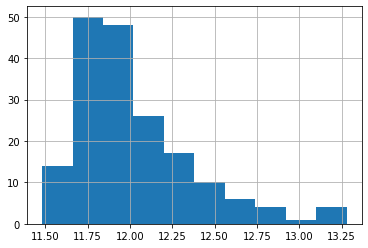

In [160]:
Y = np.log(dummy['SalePrice'])
X = dummy.drop(['SalePrice','coord'],axis = 1)
Y.hist()

In [162]:
X_columns = dummy.drop(['SalePrice','coord'],axis = 1).columns
X_columns

Index(['GrLivArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YrSinceUpdate',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
       'CentralAir', 'Total_FullBaths', 'Total_HalfBaths', 'FireplaceQu',
       'BedroomAbvGr', 'KitchenQual', 'GarageQual', 'GarageCond', 'PoolQC',
       'lat', 'lon', 'dist_stadium', 'dist_downtown', 'dist_airport',
       'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs',
       'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1Story',
       'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl',
       'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ',
       'BsmtFinType1_None', 'BsmtFinType1_Rec', 'BsmtFinType2_ALQ',
       'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_None',
       'BsmtFinType2_Rec', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv',
       'Fence_MnWw', 'Fence_None', 'MiscFeature_Gar2', 'MiscFeature_None',
       'MiscFeature_Shed'],
      dtype='object')

In [163]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X = sc.fit_transform(X)

In [164]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

reg.fit(X,Y)

LinearRegression()

In [165]:
print(reg.score(X,Y))


from sklearn.metrics import mean_squared_error
Ypred = reg.predict(X)
RMSE = mean_squared_error(Y,Ypred,squared = False)
print(RMSE)

0.9472265782895459
0.08104683575117222


In [166]:
for col, coef in zip(X_columns, reg.coef_):
    print(f'{col}: {coef}')

GrLivArea: 0.1855164963500677
OverallQual: 0.08138432072805704
OverallCond: 0.034767456636256286
YearBuilt: 0.027260429848446247
YrSinceUpdate: 0.004494677678135269
ExterQual: 0.011032774866935787
ExterCond: -0.022262420611749566
BsmtQual: 0.08179314091127252
BsmtCond: 0.02576568339730166
HeatingQC: 0.006238742125142537
CentralAir: -0.003274894406198714
Total_FullBaths: 0.03342111127962907
Total_HalfBaths: -0.0010481422056060896
FireplaceQu: 0.04501186527994164
BedroomAbvGr: -0.01278587099603751
KitchenQual: 0.009158246016120454
GarageQual: 0.015661191961492984
GarageCond: 0.008434574435875655
PoolQC: -6.245004513516506e-17
lat: 0.06225971343152782
lon: 0.017830388139522042
dist_stadium: 0.0058324230094904984
dist_downtown: 0.0560446672329563
dist_airport: -0.06060718232610801
BldgType_1Fam: 0.012451890081191443
BldgType_2fmCon: 0.01826788322468597
BldgType_Duplex: -0.0019579287385807316
BldgType_Twnhs: -0.022326077576697766
BldgType_TwnhsE: -0.01466854097451171
HouseStyle_1.5Fin: -0.0

Text(0.5, 1.0, 'Standardized feature betas in log(SalePrice) linear model')

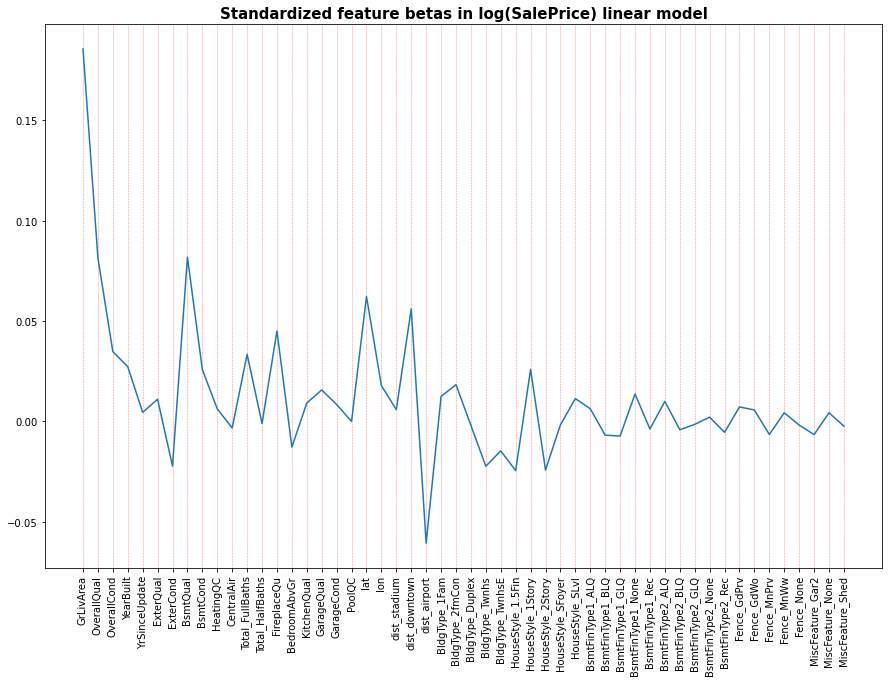

In [167]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
plt.plot(list(range(len(X_columns))),reg.coef_)
plt.xticks(list(range(len(X_columns))),labels = X_columns, rotation = 90)
plt.grid(color='r', linestyle='--', linewidth=0.5, axis = 'x',alpha = 0.5)
plt.title('Standardized feature betas in log(SalePrice) linear model', fontsize = 15, fontweight = 'bold')